# Street Fighter Tutorial
This notebook accompanies the YouTube tutorial on <a href='https://www.youtube.com/c/NicholasRenotte'>Nicholas Renotte</a>

# Setup StreetFighter

In [1]:
#!pip install gym gym-retro

In [2]:
# Import retro to play Street Fighter using a ROM
import retro
# Import time to slow down game
import time

In [3]:
# Import retro to play Street Fighter using a ROM
import retro
# Import time to slow down game
import time
import wandb


from pyvirtualdisplay import Display

#virtual_display = Display(visible=0, size=(1400, 900))
#virtual_display.start()

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

In [4]:
# See the different retro games
#retro.data.list_games()

In [5]:
# python -m retro.import . # Run this from the roms folder, or where you have your game roms 

# Setup Environment
## What we are going to do! FUNNN
- Observation Preprocess - grayscale (DONE), frame delta, resize the frame so we have less pixels  (DONE) 
- Filter the action - parameter DONE
- Reward function - set this to the score

In [6]:
!pip install opencv-python

In [7]:
# Import environment base class for a wrapper 
from gym import Env 
# Import the space shapes for the environment
from gym.spaces import MultiBinary, Box
# Import numpy to calculate frame delta 
import numpy as np
# Import opencv for grayscaling
import cv2
# Import matplotlib for plotting the image
from matplotlib import pyplot as plt

import wandb

In [8]:
# Create custom environment 
class StreetFighter(Env): 
    def __init__(self):
        super().__init__()
        # Specify action space and observation space 
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        self.action_space = MultiBinary(12)
        # Startup and instance of the game 
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.FILTERED)
    
    def reset(self):
        # Return the first frame 
        obs = self.game.reset()
        obs = self.preprocess(obs) 
        self.previous_frame = obs 
        
        # Create a attribute to hold the score delta 
        self.score = 0 
        return obs
    
    def preprocess(self, observation): 
        # Grayscaling 
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        # Resize 
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        # Add the channels value
        channels = np.reshape(resize, (84,84,1))
        return channels 
    
    def step(self, action): 
        # Take a step 
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs) 
        
        # Frame delta 
        frame_delta = obs - self.previous_frame
        self.previous_frame = obs 
        
        # Reshape the reward function
        reward = info['score'] - self.score 
        self.score = info['score'] 
        
        return frame_delta, reward, done, info
    
    def render(self, *args, **kwargs):
        self.game.render()
        
    def close(self):
        self.game.close()

In [10]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
Aborted!


In [11]:
# 先 login, 如果要切換帳號可以在 command line 打 `wandb login --relogin`
# 這行會要求你去 https://wandb.ai/authorize 拿取屬於自己的 api key
# 複製 api key 貼上 (即使是在同個 team 不同人會拿到不同的 key)
wandb.login()

# 我們的 team 是 'ntuai2023'，這個要設在 `wandb.init()` 的 `entity` 參數
# team 底下的 project 是`sf2`
WANDB_PROJECT='sf2'
wandb.init(project=WANDB_PROJECT, entity='ntuai2023', settings=wandb.Settings(start_method="fork"))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


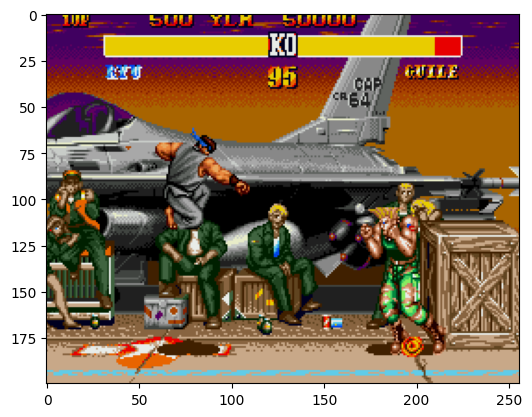

In [12]:
env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis')

# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    img = plt.imshow(env.render(mode='rgb_array')) 
    epoch = 0
    while not done and epoch < 300: 
        if done: 
            obs = env.reset()
        #env.render()
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)

        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)
        if reward > 0: 
            print(reward)

        wandb.log({"reward": reward})
        epoch += 1

env.close()

In [ ]:
obs = env.reset()

In [ ]:
obs, reward, done, info = env.step(env.action_space.sample())

In [ ]:
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))

# Hyperparameter tune

In [ ]:
!pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [ ]:
!pip install stable-baselines3[extra] optuna

In [ ]:
# Importing the optimzation frame - HPO
import optuna
# PPO algo for RL
from stable_baselines3 import PPO
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
# Import the sb3 monitor for logging 
from stable_baselines3.common.monitor import Monitor
# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# Import os to deal with filepaths
import os

In [ ]:
LOG_DIR = './logs/'
OPT_DIR = './opt/'

In [ ]:
# Function to return test hyperparameters - define the object function
def optimize_ppo(trial): 
    return {
        'n_steps':trial.suggest_int('n_steps', 2048, 8192),
        'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4),
        'clip_range':trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda':trial.suggest_uniform('gae_lambda', 0.8, 0.99)
    }

In [ ]:
SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(1))

In [ ]:
# Run a training loop and return mean reward 
def optimize_agent(trial):
    try:
        model_params = optimize_ppo(trial) 

        # Create environment 
        env = StreetFighter()
        env = Monitor(env, LOG_DIR)
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')

        # Create algo 
        model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params)
        model.learn(total_timesteps=30000)
        #model.learn(total_timesteps=100000)

        # Evaluate model 
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        return mean_reward

    except Exception as e:
        return -1000

In [ ]:
# Creating the experiment 
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=10, n_jobs=1)
#study.optimize(optimize_agent, n_trials=100, n_jobs=1)

In [ ]:
study.best_params

In [ ]:
study.best_trial

In [ ]:
model = PPO.load(os.path.join(OPT_DIR, 'trial_5_best_model.zip'))

# Setup Callback

In [ ]:
# Import base callback 
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
CHECKPOINT_DIR = './train/'

In [ ]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# Train Model

In [ ]:
# Create environment 
env = StreetFighter()
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

In [ ]:
model_params = study.best_params
model_params['n_steps'] = 7488  # set n_steps to 7488 or a factor of 64
# model_params['learning_rate'] = 5e-7
model_params

In [ ]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, **model_params)

In [ ]:
# Reload previous weights from HPO
model.load(os.path.join(OPT_DIR, 'trial_5_best_model.zip'))

In [ ]:
# Kick off training 
model.learn(total_timesteps=100000, callback=callback)
# model.learn(total_timestep=5000000) 

# Evaluate the Model

In [ ]:
model = PPO.load('./opt/trial_5_best_model.zip')

In [ ]:
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)

In [ ]:
mean_reward

# Test out the Model

In [ ]:
obs = env.reset()

In [ ]:
obs.shape

In [ ]:
env.step(model.predict(obs)[0])

In [ ]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        action = model.predict(obs)[0]
        obs, reward, done, info = env.step(action)
        time.sleep(0.01)
        print(reward)